This notebook is used to compile all our models and compare them along with some standardized format. Make sure your code output fits as input to this standardized format, such that it only needs to be imported and can run from the get-go.

I'll also build some plotter to make this work well and of course ensure there is proper docstrings and comments

(If you want to make your folder importable, like I did with Code_Emiel, simply add an empty __init__.py to the folder)

In [51]:
import os
import sys

# sys.path.append(os.getcwd())

In [52]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors

from scipy.stats import chi2

import matplotlib.pyplot as plt
import seaborn as sns

from rpca.rpca import RobustPCA
import pyrpca
import sys
print(sys.prefix)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
import time

c:\Users\EmielNagel\Documents\Personal Software\Professional Workfield Code\AI-in-the-Professional-Workfield-Code-main\.venv


In [53]:
def plot(title, matrix, models, M):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    sns.heatmap(
        matrix,
        annot=True,            # show the numbers
        fmt=".2f",             # two decimals
        cmap="viridis",
        xticklabels=models,
        yticklabels=models,
        mask=np.isnan(matrix), # hides NaN cells
        square=True,
        cbar_kws={'shrink': 0.6},
        ax=ax1
    )
    # cax = ax.imshow(matrix, cmap='viridis', interpolation='nearest')
    # fig.colorbar(cax, ax=ax)
    ax1.set_xticks(range(M))
    ax1.set_xticklabels(models, rotation=90)
    ax1.set_yticks(range(M))
    ax1.set_yticklabels(models)
    ax1.set_title(title, pad=20)

    cax = ax2.imshow(matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax, ax=ax2)
    ax2.set_xticks(range(len(models)))
    ax2.set_xticklabels(models, rotation=90)
    ax2.set_yticks(range(len(models)))
    ax2.set_yticklabels(models)
    ax2.set_title(title + "\n(same plot but with clearer x and y labels)", pad=20)
    fig.subplots_adjust(wspace=0.7)
    plt.show()

In [54]:
# Standard format

from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

class StandardFormat:
    def __init__(self, n_samples):
        self.detected_outliers = {}
        self.confidences = {}
        self.n_samples = n_samples

    def add_outlier_samples(self, model_name: str, outliers: List[str]):
        """
        model_name: str = the name of your model of which you want to add the outliers to the pool

        outliers: list = the list of sample/measurement names (don't add anything else besides that, just the names of the samples (sample_1, sample_4567, etc)) (the length of the list doesn't matter, it can be any length, ensuring the alpha is 0.05)

        Call this function to add identified samples to the data pool
        With that I mean the following:
        with a certain alpha value, you select which samples are identified to be outliers.

        For this alpha, make sure you take 0.05! (standard alpha value)

        This is important, else we're comparing apples with oranges.
        """
        
        assert all(isinstance(item, str) for item in outliers), "Outliers should be a list of strings"
        self.detected_outliers.update({model_name: outliers})

    def add_confidences(self, model_name: str, confidences: List[Tuple[str, float]]):
        """
        model_name: str = the name of your model of which you want to add the confidences to the pool

        confidences: list = the list of (sample_name, confidence values) (probabilities between 0 and 1 that this sample or measurement is an outlier) (don't add anything else besides that, just the confidence values)

        Call this function to add identified samples to the data pool
        We're specifically NOT working with alpha values in this one
        Ensure that the raw confidence values of something being an outlier are added here
        What is the confidence value? A probability between 0 and 1 that this sample or measurement is an outlier, with 1 being fully confident that it IS an outlier, and vice versa.
    
        Ensure that the length of the confidences list is the same as the length of the entire dataset (so make sure that all samples are in the list, and nothing more or less. I will assert this, it will crash if the length is off!).
        """
        if self.n_samples is not None and len(confidences) != self.n_samples:
            raise ValueError(f"Expected {self.n_samples} confidences, got {len(confidences)}")
        self.confidences.update({model_name: confidences})

    def compute_similarity_scores_detected_outliers(self, plot_results: bool = False):
        models = list(self.detected_outliers)
        M = len(models)
        matrix = np.zeros((M, M), dtype=float)

        for i, model_name in enumerate(models):
            si = set(self.detected_outliers[model_name])
            for j, other_model_name in enumerate(models):
                if i == j:
                    matrix[i, j] = np.nan  # Diagonal can be set to NaN or 0 as preferred
                else:
                    sj = set(self.detected_outliers[other_model_name])
                    union = len(si | sj)
                    matrix[i, j] = (len(si & sj) / union) if union else np.nan

        if plot_results:
            plot("Similarity Matrix of Detected Outliers", matrix, models, M)
        return models, matrix

    def compute_similarity_scores_confidences(self, plot_results: bool = False):
        models = list(self.confidences)
        M = len(models)
        sorted_confidences = {
            m: sorted(self.confidences[m], key=lambda x: x[0])
            for m in models
        }
        X = np.vstack([
            [conf for (_sid, conf) in sorted_confidences[m]]
            for m in models
        ])
        matrix = cosine_similarity(X)
        np.fill_diagonal(matrix, np.nan)

        if plot_results:
            plot("Similarity Matrix of Confidences", matrix, models, M)
        return models, matrix

standard_format = StandardFormat(20446)

In [67]:
def compute_model_agreement_weights(models, similarity_matrix):
    """
    Returns a dict of model_name -> agreement_weight (float between 0 and 1)
    where higher means more 'inlier', lower is more 'outlier'.
    """
    agreement = {}
    for i, model in enumerate(models):
        # Ignore nan values (the diagonal)
        scores = [similarity_matrix[i, j] for j in range(len(models)) if i != j and not np.isnan(similarity_matrix[i, j])]
        if scores:
            avg_similarity = np.mean(scores)
        else:
            avg_similarity = 0.0
        agreement[model] = avg_similarity

    # Normalize to [0, 1] for interpretability (optional, but recommended)
    values = np.array(list(agreement.values()))
    min_val, max_val = np.nanmin(values), np.nanmax(values)
    if max_val > min_val:
        for k in agreement:
            agreement[k] = (agreement[k] - min_val) / (max_val - min_val)
    else:
        # All models are equally similar; set all to 1
        for k in agreement:
            agreement[k] = 1.0
    
    summed_agreement = sum(agreement.values())
    normed_agreement = {k: v / summed_agreement for k, v in agreement.items()}
    return normed_agreement

**Emiel's code:**

In [56]:
def fetch_data_1():
    # Load the dataset
    dataset = pd.read_csv('Dataset/refData_obf.csv')

    cols = dataset.columns
    raw_features = dataset.loc[:, cols[1:]].values              # Exclude the sample names (index 0) from features
    sample_names = dataset.loc[:, cols[0]].values              # Sample names are in the first column

    mask = ~np.isnan(raw_features).any(axis=1)
    features = raw_features[mask]                               # Drop samples with some missing values
    good_sample_names = sample_names[mask]                          # Keep the sample names corresponding to the features

    bad_sample_names = sample_names[~mask]                      # Sample names with missing values

    scaled_features = StandardScaler().fit_transform(features)  # Standardize the features
    features_pca = PCA(n_components=2).fit_transform(scaled_features)
    return dataset, good_sample_names, bad_sample_names, raw_features, features, scaled_features, features_pca

def detect_outliers(outlier_detector, sample_names, features, alpha=0.05):
    squared_distances = outlier_detector.decision_function(features)
    distances = np.sqrt(np.abs(squared_distances))  # Convert to distances
    print("Max:", np.max(distances), "Min:", np.min(distances))

    p_values = chi2.cdf(distances, df=outlier_detector.n_features_in_)
    is_outlier = p_values > (1 - alpha)
    outlier_names = list(sample_names[is_outlier])
    confidences = p_values
    pct = is_outlier.sum() / len(features) * 100
    return outlier_names, confidences, pct

# def plot(data, title, xlabel, ylabel, extra_plots=[]):
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x=np.arange(len(data)), y=data)
#     for extra_plot in extra_plots:
#         extra_plot()
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

def emiel_elliptic_envelope_main():
    alpha = 0.05
    dataset, good_sample_names, bad_sample_names, raw_features, features, scaled_features, features_pca = fetch_data_1()
    selected_data = [dataset, raw_features, features, scaled_features, features_pca][2]
    
    outlier_detector = EllipticEnvelope(contamination=0.49, support_fraction=1, random_state=42)
    outlier_detector.fit(features)

    squared_distances = outlier_detector.decision_function(features)
    distances = np.sqrt(np.abs(squared_distances))  # Convert to distances
    print("Max:", np.max(distances), "Min:", np.min(distances))

    p_values = chi2.cdf(distances, df=outlier_detector.n_features_in_)
    is_outlier = p_values > (1 - alpha)
    outlier_names = list(good_sample_names[is_outlier])
    confidences = [(sample_name, p_value) for sample_name, p_value in zip(good_sample_names, p_values)]      # Compile confidence values
    confidences += [(sample_name, 0.0) for sample_name in bad_sample_names]                                  # Add 0.0 confidence for samples with missing values

    pct = is_outlier.sum() / len(features) * 100


    # Detect outliers in the dataset
    # outlier_names, confidences, pct = detect_outliers(outlier_detector, raw_features, alpha)
    print(f"{len(outlier_names)} outliers ({pct:.2f}% of samples):")
    print(outlier_names)

    # extra_plots = [lambda: plt.axhline(y=1-alpha, color='r', linestyle='--', label=f'Selection Threshold: alpha = {alpha}')]
    # plot(outlier_probabilities, "Outlier Probabilities", "Sample Index", "Outlier Probability", extra_plots)
    return outlier_names, confidences

In [57]:
def fetch_data_2():
    # Load the dataset
    dataset = pd.read_csv('Dataset/refData_obf.csv')

    cols = dataset.columns
    features = dataset.loc[:, cols[1:]].values              # Exclude the sample names (index 0) from features
    sample_names = dataset.loc[:, cols[0]].values              # Sample names are in the first column
    
    mask = ~np.isnan(features).any(axis=1)
    features = features[mask]                               # Drop samples with some missing values
    good_sample_names = sample_names[mask]                          # Keep the sample names corresponding to the features
    bad_sample_names = sample_names[~mask]                      # Sample names with missing values

    return dataset, features, good_sample_names, bad_sample_names

# def plot(rpca_data, pyrpca_data, title, xlabel, ylabel, extra_plots=[]):
#     if extra_plots is None:
#         extra_plots = []

#     fig, ax1 = plt.subplots(figsize=(10, 6))
#     idx = np.arange(len(rpca_data))

#     # ── RPCA on ax1 (blue) ────────────────────────────────────────────────────
#     sns.scatterplot(x=idx, y=rpca_data, ax=ax1, label="RPCA", color="tab:blue")
#     ax1.set_xlabel(xlabel)
#     ax1.set_ylabel(ylabel + " (RPCA)", color="tab:blue")
#     ax1.tick_params(axis="y", labelcolor="tab:blue")

#     # ── pyrpca on a twin axis (red) ──────────────────────────────────────────
#     ax2 = ax1.twinx()
#     sns.scatterplot(
#         x=idx,
#         y=pyrpca_data,
#         ax=ax2,
#         label="pyrpca",
#         marker="x",
#         color="tab:red",
#     )
#     ax2.set_ylabel(ylabel + " (pyrpca)", color="tab:red")
#     ax2.tick_params(axis="y", labelcolor="tab:red")

#     # ── Extra decorations provided by caller ────────────────────────────────
#     for fn in extra_plots:
#         fn(ax1)          # pass the primary axis so callers can draw on it

#     # Combine the two legends
#     # h1, l1 = ax1.get_legend_handles_labels()
#     # h2, l2 = ax2.get_legend_handles_labels()
#     # ax1.legend(h1 + h2, l1 + l2, loc="best")

#     ax1.set_title(title)
#     fig.tight_layout()
#     plt.show()

def norm_to_prob(x: np.ndarray) -> np.ndarray:
    """Convert a non-negative 1-D array to a probability distribution."""
    total = x.sum()
    if total == 0:
        return np.full_like(x, 1 / len(x), dtype=float)
    return x / total

def rpca_pipeline(alpha, x):
    rpca = RobustPCA(max_iter=10000, tol=1e-6).fit(x)           # robust decomposition
    L, S = rpca.L_, rpca.S_           # robust decomposition
    
    print("Estimated rank(L):", np.linalg.matrix_rank(L))
    print(L.shape)
    print(S.shape)

    row_outlier_score = np.abs(S).sum(axis=1)
    print("Row outlier scores:", row_outlier_score)
    row_probs = norm_to_prob(row_outlier_score)

    cutoff = np.percentile(row_outlier_score, 100 * (1 - alpha))
    print(f"{100*(1-alpha):.1f}th percentile (cutoff):", cutoff)

    suspect_rows = np.where(row_outlier_score > cutoff)[0]
    print(f"Top-{alpha} % outlier rows:", suspect_rows)

    return row_outlier_score, row_probs, suspect_rows

    plot(row_outlier_score, title="Rpca Row Outlier Scores", xlabel="Row index", ylabel="‖S‖₁ per row",
        extra_plots=[lambda: plt.axhline(cutoff, linestyle="--", label=f"Cutoff={cutoff:.2f}")]
    )

def pyrpca_pipeline(alpha, x):
    sparsity = lambda x: 1/np.sqrt(max(x.shape))
    print("Sparsity:", sparsity(x))
    L_hat, S_hat = pyrpca.rpca_pcp_ialm(x, sparsity(x))

    print("Estimated rank(L):", np.linalg.matrix_rank(L_hat))
    print(L_hat.shape)
    print(S_hat.shape)
    
    row_outlier_score = np.abs(S_hat).sum(axis=1)
    print("Row outlier scores:", row_outlier_score)
    row_probs = norm_to_prob(row_outlier_score)

    cutoff = np.percentile(row_outlier_score, 100 * (1 - alpha))
    print(f"{100*(1-alpha):.1f}th percentile (cutoff):", cutoff)

    suspect_rows = np.where(row_outlier_score > cutoff)[0]
    print(f"Top-{alpha} % outlier rows:", suspect_rows)

    return row_outlier_score, row_probs, suspect_rows

    plot(row_outlier_score, title="Pyrpca Row Outlier Scores", xlabel="Row index", ylabel="‖S‖₁ per row",
        extra_plots=[lambda: plt.axhline(cutoff, linestyle="--", label=f"Cutoff={cutoff:.2f}")]
    )

def export_suspects_to_excel(
    dataset: pd.DataFrame,
    rpca_suspects: np.ndarray,
    pyrpca_suspects: np.ndarray,
    file_path: str = "Output/RPCA suspect_samples.xlsx",
):
    """Write the suspect rows into an Excel workbook.

    Parameters
    ----------
    dataset : DataFrame
        The full, clean dataset (after NaN removal).
    rpca_suspects : array-like of int
        Row indices flagged by the RPCA pipeline.
    pyrpca_suspects : array-like of int
        Row indices flagged by the pyrpca pipeline.
    file_path : str, optional
        Destination Excel file (default: ``suspect_rows.xlsx``).
    """
    rpca_df = dataset.iloc[rpca_suspects].copy()
    pyrpca_df = dataset.iloc[pyrpca_suspects].copy()
    combined_df = dataset.iloc[np.union1d(rpca_suspects, pyrpca_suspects)].copy()

    with pd.ExcelWriter(file_path, engine="xlsxwriter") as writer:
        rpca_df.to_excel(writer, sheet_name="RPCA", index=False)
        pyrpca_df.to_excel(writer, sheet_name="pyrpca", index=False)
        combined_df.to_excel(writer, sheet_name="Combined", index=False)

    print(f"✓ Suspect rows exported to '{file_path}'.")

def rpca_emiel_main():
    alpha = 0.05
    dataset, features, good_sample_names, bad_sample_names = fetch_data_2()
    print(features.shape)

    x = StandardScaler(with_mean=True, with_std=True).fit_transform(features)
    rpca_values = rpca_pipeline(alpha, x)
    pyrpca_values = pyrpca_pipeline(alpha, x)
    # plot(rpca_values[0], pyrpca_values[0],
    #     title="Row Outlier Scores",
    #     xlabel="Row index",
    #     ylabel="‖S‖₁ per row",
    #     # extra_plots=[lambda ax: ax.axhline(cutoff, ls="--", color="k")]
    # )
    export_suspects_to_excel(dataset, rpca_values[2], pyrpca_values[2])
    rpca_outlier_names = good_sample_names[rpca_values[2]]
    rpca_confidences = [(sample_name, p_value) for sample_name, p_value in zip(good_sample_names, rpca_values[1])]      # Compile confidence values
    rpca_confidences += [(sample_name, 0.0) for sample_name in bad_sample_names]                                  # Add 0.0 confidence for samples with missing values
    pyrpca_outlier_names = good_sample_names[pyrpca_values[2]]
    pyrpca_confidences = [(sample_name, p_value) for sample_name, p_value in zip(good_sample_names, pyrpca_values[1])]      # Compile confidence values
    pyrpca_confidences += [(sample_name, 0.0) for sample_name in bad_sample_names]                                  # Add 0.0 confidence for samples with missing values
    
    # rpca = RobustPCA(max_iter=10000, tol=1e-6).fit(x)           # robust decomposition
    # L, S = rpca.L_, rpca.S_           # robust decomposition

    # print("Estimated rank(L):", np.linalg.matrix_rank(L))
    # print(L.shape)
    # print(S.shape)

    # row_outlier_score = np.abs(S).sum(axis=1)
    # print(row_outlier_score)

    # cutoff = np.percentile(row_outlier_score, 100 * (1 - alpha))
    # print(f"{100*(1-alpha):.1f}th percentile (cutoff):", cutoff)

    # suspect_rows = np.where(row_outlier_score > cutoff)[0]
    # print(f"Top-{alpha} % outlier rows:", suspect_rows)

    # plot(row_outlier_score, title="Row Outlier Scores", xlabel="Row index", ylabel="‖S‖₁ per row",
    #     extra_plots=[lambda: plt.axhline(cutoff, linestyle="--", label=f"Cutoff={cutoff:.2f}")]
    # )
    return rpca_outlier_names, rpca_confidences, pyrpca_outlier_names, pyrpca_confidences

In [58]:
outliers, confidences = emiel_elliptic_envelope_main()
standard_format.add_outlier_samples("Elliptic Envelope Emiel", outliers)
standard_format.add_confidences("Elliptic Envelope Emiel", confidences)

rpca_outliers, rpca_confidences, pyrpca_outliers, pyrpca_confidences = rpca_emiel_main()
standard_format.add_outlier_samples("Robust PCA Emiel (rpca)", rpca_outliers)
standard_format.add_confidences("Robust PCA Emiel (rpca)", rpca_confidences)
standard_format.add_outlier_samples("Robust PCA Emiel (pyrpca)", pyrpca_outliers)
standard_format.add_confidences("Robust PCA Emiel (pyrpca)", pyrpca_confidences)

Max: 3700.224392353503 Min: 0.010070621888116572
382 outliers (2.06% of samples):
['sample_10076', 'sample_10104', 'sample_10152', 'sample_10203', 'sample_10224', 'sample_10270', 'sample_10306', 'sample_10332', 'sample_10377', 'sample_10384', 'sample_10388', 'sample_10444', 'sample_10652', 'sample_10659', 'sample_10669', 'sample_10821', 'sample_1093', 'sample_10930', 'sample_10944', 'sample_1096', 'sample_10963', 'sample_10967', 'sample_10973', 'sample_11030', 'sample_11067', 'sample_11131', 'sample_11239', 'sample_11280', 'sample_11287', 'sample_11316', 'sample_11331', 'sample_11414', 'sample_11465', 'sample_11534', 'sample_1159', 'sample_11601', 'sample_11796', 'sample_11820', 'sample_11860', 'sample_11864', 'sample_11865', 'sample_11871', 'sample_11886', 'sample_11924', 'sample_11946', 'sample_11987', 'sample_12054', 'sample_12148', 'sample_12156', 'sample_12198', 'sample_12205', 'sample_1222', 'sample_12284', 'sample_12286', 'sample_12298', 'sample_123', 'sample_12402', 'sample_124

**Nicolas' code:**

In [59]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from joblib import Parallel, delayed
from scipy.stats import rankdata


In [60]:
# 1) Load and split
print("Loading data...")
df = pd.read_csv('Dataset/refData_obf.csv')
df_num = df.select_dtypes(include=[np.number])
print(f"Total samples (with NaNs): {df_num.shape[0]}")

train_df = df_num.dropna()
test_df  = df_num.copy()
print(f"Training on complete cases only: {train_df.shape[0]} rows")

# 2) Compute medians on train, fill test NaNs
medians = train_df.median()
test_filled = test_df.fillna(medians)

# 3) Fit scaler on train, then scale both
print("Fitting scaler and standardizing features…")
scaler = StandardScaler().fit(train_df)
X_train = scaler.transform(train_df)
X_test  = scaler.transform(test_filled)    # safe because no NaNs remain
n_samples, n_features = X_test.shape

# 4) Isolation Forest
print("Training Isolation Forest…")
iso = IsolationForest(random_state=42, n_jobs=-1).fit(X_train)
iso_scores = -iso.decision_function(X_test)
print(" → done.")

# 5) Elliptic Envelope
print("Training Elliptic Envelope…")
env = EllipticEnvelope(contamination=0.01).fit(X_train)
env_scores = -env.decision_function(X_test)
print(" → done.")

# 6) Autoencoder proxy
print("Training autoencoder proxy (MLPRegressor)…")
mlp = MLPRegressor(hidden_layer_sizes=(max(1, n_features//2),),
                   activation='relu', max_iter=200,
                   random_state=42)
mlp.fit(X_train, X_train)
ae_scores = np.mean((X_test - mlp.predict(X_test))**2, axis=1)
print(" → done.")

Loading data...
Total samples (with NaNs): 20446
Training on complete cases only: 18548 rows
Fitting scaler and standardizing features…
Training Isolation Forest…
 → done.
Training Elliptic Envelope…
 → done.
Training autoencoder proxy (MLPRegressor)…
 → done.


In [ ]:
def compute_residuals(j):
    idx = [k for k in range(n_features) if k != j]
    rf = RandomForestRegressor(n_estimators=100,
                               random_state=42,
                               n_jobs=-1)
    rf.fit(X_train[:, idx], X_train[:, j])
    return np.abs(X_test[:, j] - rf.predict(X_test[:, idx]))

print("Computing regression-residual scores in parallel…")
resid_list = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_residuals)(j) for j in range(n_features)
)
resid_matrix = np.vstack(resid_list).T
resid_scores = StandardScaler().fit_transform(resid_matrix).mean(axis=1)
print(" → done.")


print("Fusing anomaly scores…")
def zscore(v): return (v - v.mean()) / v.std()
all_z = np.vstack([ zscore(iso_scores),
                    zscore(env_scores),
                    zscore(ae_scores),
                    zscore(resid_scores) ]).T
fused_score = all_z.mean(axis=1)

#top 1% are outliers
threshold = np.percentile(fused_score, 99)
mask = fused_score > threshold
sample_ids = df_num.index.astype(str)
outliers  = sample_ids[mask].tolist()
print(f"Flagged {len(outliers)} outliers (fused_score > {threshold:.2f})")

# confidences for every sample
ranks        = rankdata(fused_score)     # 1..n_samples
conf_percent = ranks / n_samples         # scaled to (0,1]
confidences  = list(zip(sample_ids, conf_percent))

#results
standard_format.add_outlier_samples("Regression-Residual Fusion", outliers)
standard_format.add_confidences("Regression-Residual Fusion", confidences)

Computing regression–residual scores in parallel…


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  34 out of  51 | elapsed: 12.3min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  40 out of  51 | elapsed: 14.3min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  46 out of  51 | elapsed: 15.9min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 16.0min finished


 → done.
Fusing anomaly scores…
Flagged 205 outliers (fused_score > 1.64)


**Abhinav's code:**

In [62]:
def run_mlip_autoencoder_lean(
    file_path, sample_id_col_name,
    hidden_dim_1=1024, 
    hidden_dim_2=640, 
    encoding_dim=18,
    learning_rate=0.001, 
    epochs=150, 
    batch_size=32, 
    validation_split_ratio=0.1,
    scheduler_factor=0.1, 
    scheduler_patience=7, 
    scheduler_min_lr=1e-7,
    early_stopping_patience=20, 
    alpha_outliers=0.05,
    conf_scale_type="mean",
    epsilon_conf=1e-9
):
    _verbose = True 
    _use_tqdm = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    df = pd.read_csv(file_path)
    feature_cols = [col for col in df.columns if col != sample_id_col_name]
    all_sids = df[sample_id_col_name].tolist()
    
    data_numeric = df[feature_cols].apply(pd.to_numeric, errors='coerce')
    initial_indices = df.index
    data_numeric.index = initial_indices
    
    nan_mask = data_numeric.isnull().any(axis=1)
    scaled_data, proc_sids_df, proc_indices = None, None, None

    if nan_mask.any():
        data_no_na = data_numeric[~nan_mask]
        if data_no_na.empty: return [], [(sid, 0.0) for sid in all_sids]
        proc_indices = initial_indices[~nan_mask]
        proc_sids_df = df.loc[proc_indices, [sample_id_col_name]].copy()
        scaler = StandardScaler().fit(data_no_na)
        scaled_data = scaler.transform(data_no_na)
    else:
        proc_indices = initial_indices
        proc_sids_df = df.loc[proc_indices, [sample_id_col_name]].copy()
        scaler = StandardScaler().fit(data_numeric)
        scaled_data = scaler.transform(data_numeric)
    
    if scaled_data is None or scaled_data.shape[0] == 0:
        return [], [(sid, 0.0) for sid in all_sids]

    input_dim = len(feature_cols)

    class SoilDataset(Dataset):
        def __init__(self, d): self.data = torch.tensor(d, dtype=torch.float32)
        def __len__(self): return len(self.data)
        def __getitem__(self, i): return self.data[i], self.data[i]

    ds_proc = SoilDataset(scaled_data)
    val_loader, train_ds = None, ds_proc
    if validation_split_ratio > 0 and len(ds_proc) * validation_split_ratio >= 1:
        v_size = int(len(ds_proc) * validation_split_ratio)
        t_size = len(ds_proc) - v_size
        if t_size > 0:
            train_ds, v_ds_sub = random_split(ds_proc, [t_size, v_size], generator=torch.Generator().manual_seed(42))
            val_loader = DataLoader(v_ds_sub, batch_size=batch_size, shuffle=False, num_workers=0)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    processed_loader = DataLoader(ds_proc, batch_size=batch_size, shuffle=False, num_workers=0)

    class Autoencoder(nn.Module):
        def __init__(self, idim, edim, h1, h2): super().__init__(); self.enc=nn.Sequential(nn.Linear(idim,h1),nn.ReLU(),nn.Linear(h1,h2),nn.ReLU(),nn.Linear(h2,edim),nn.ReLU()); self.dec=nn.Sequential(nn.Linear(edim,h2),nn.ReLU(),nn.Linear(h2,h1),nn.ReLU(),nn.Linear(h1,idim))
        def forward(self,x): return self.dec(self.enc(x))
    model=Autoencoder(input_dim, encoding_dim, hidden_dim_1, hidden_dim_2).to(device)

    crit=nn.MSELoss(); opt=optim.Adam(model.parameters(),lr=learning_rate)
    sched = ReduceLROnPlateau(opt, 'min', factor=scheduler_factor, patience=scheduler_patience, min_lr=scheduler_min_lr)

    def _train_ep(m, dl, c, o, dv, ep, te):
        m.train(); tl = 0.0; bp = tqdm(dl, f"E {ep}/{te} Trn", leave=False, ncols=100, disable=not _use_tqdm)
        for i,t in bp: i,t=i.to(dv),t.to(dv); o.zero_grad(); ou=m(i); ls=c(ou,t); ls.backward(); o.step(); tl+=ls.item()*i.size(0)
        return tl/len(dl.dataset) if len(dl.dataset)>0 else 0.0

    def _eval_ep(m, dl, c, dv, ep, te):
        if dl is None or len(dl.dataset)==0: return float('nan')
        m.eval(); tl = 0.0; bp = tqdm(dl, f"E {ep}/{te} Val", leave=False, ncols=100, disable=not _use_tqdm)
        with torch.no_grad():
            for i,t in bp: i,t=i.to(dv),t.to(dv); ou=m(i); ls=c(ou,t); tl+=ls.item()*i.size(0)
        return tl/len(dl.dataset) if len(dl.dataset)>0 else float('nan')

    best_vloss, es_cnt = float('inf'), 0
    if len(train_loader.dataset) > 0:
        ep_prog = tqdm(range(epochs), "MLIP Train", ncols=100, disable=not _use_tqdm)
        for ep in ep_prog:
            _train_ep(model,train_loader,crit,opt,device,ep+1,epochs)
            vloss = _eval_ep(model,val_loader,crit,device,ep+1,epochs) if val_loader else float('nan')
            if val_loader and not np.isnan(vloss):
                sched.step(vloss)
                if vloss < best_vloss: best_vloss=vloss; es_cnt=0
                else:
                    es_cnt+=1
                    if es_cnt >= early_stopping_patience: break
        if not ep_prog.disable and _use_tqdm: ep_prog.close()

    model.eval(); o_l, r_l = [],[]
    rec_prog = tqdm(processed_loader, "MLIP Recon", ncols=100, disable=not _use_tqdm)
    with torch.no_grad():
        for i,_ in rec_prog: o_l.append(i.cpu().numpy()); r_l.append(model(i.to(device)).cpu().numpy())
    if not o_l: return [], [(sid, 0.0) for sid in all_sids]

    orig_a = np.concatenate(o_l); recon_a = np.concatenate(r_l)
    feat_err = pd.DataFrame((orig_a-recon_a)**2, columns=feature_cols, index=proc_indices)

    m_in_conf = pd.DataFrame(index=proc_indices, columns=feature_cols, dtype=float)
    for f_n in feature_cols:
        ers = feat_err[f_n]
        if ers.empty or ers.max()==0: m_in_conf[f_n]=1.0; continue
        ce = ers.mean() if conf_scale_type=="mean" else ers.median() if conf_scale_type=="median" else ers.quantile(0.95) if conf_scale_type=="p95" else ers.mean()
        kj = 1.0/(ce if ce>=epsilon_conf else epsilon_conf); m_in_conf[f_n]=np.exp(-kj*ers)
    m_in_conf = m_in_conf.clip(0.0,1.0)

    s_avg_in_c = m_in_conf.mean(axis=1)
    df_in_c_p = proc_sids_df.copy()
    df_in_c_p["InlierConf"] = s_avg_in_c.values

    out_sfmt = []
    if not df_in_c_p.empty and alpha_outliers > 0:
        n_o = round(alpha_outliers * len(df_in_c_p))
        if n_o > 0: out_sfmt = df_in_c_p.nsmallest(n_o, "InlierConf")[sample_id_col_name].tolist()
    
    proc_map = {r[sample_id_col_name]:1.0-r["InlierConf"] for _,r in df_in_c_p.iterrows()}
    conf_sfmt = [(sid, proc_map.get(sid, 0.0)) for sid in all_sids]
        
    return out_sfmt, conf_sfmt

In [63]:
DEFAULT_FILE = 'Dataset/refData_obf.csv'
DEFAULT_SID_COL = 'SampleId'


mlip_outliers, mlip_confidences = run_mlip_autoencoder_lean(
    file_path=DEFAULT_FILE,
    sample_id_col_name=DEFAULT_SID_COL,
    epochs=50, 
    alpha_outliers=0.05
)

standard_format.add_outlier_samples("MLIP Autoencoder Abhinav (UltraLean)", mlip_outliers)
standard_format.add_confidences("MLIP Autoencoder Abhinav (UltraLean)", mlip_confidences)

MLIP Recon: 100%|████████████████████████████████████████████████| 580/580 [00:00<00:00, 686.04it/s]


**Patricia's code:**

In [64]:
def normalize_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    if max_score == min_score:
        return [0.0 for _ in scores]
    return [(s - min_score) / (max_score - min_score) for s in scores]

def out_detect_LOF(data_scaled, cleaned_indices, df_full):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_labels = lof.fit_predict(data_scaled)
    lof_scores = -lof.negative_outlier_factor_

    outliers = cleaned_indices[lof_labels == -1]
    outlier_names = [f"sample_{i}" for i in outliers]

    scores_dict = {i: score for i, score in zip(cleaned_indices, lof_scores)}
    all_scores = [scores_dict.get(i, 0.0) for i in df_full.index]
    conf = list(zip([f"sample_{i}" for i in df_full.index], normalize_scores(all_scores)))
    return outlier_names, conf

def out_detect_kNN(data_scaled, cleaned_indices, df_full):
    k = 20
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data_scaled)
    distances, _ = neigh.kneighbors(data_scaled)
    knn_scores = distances.mean(axis=1)
    threshold = np.percentile(knn_scores, 95)
    knn_flags = knn_scores > threshold

    outliers = cleaned_indices[knn_flags]
    outlier_names = [f"sample_{i}" for i in outliers]

    scores_dict = {i: score for i, score in zip(cleaned_indices, knn_scores)}
    all_scores = [scores_dict.get(i, 0.0) for i in df_full.index]
    conf = list(zip([f"sample_{i}" for i in df_full.index], normalize_scores(all_scores)))
    return outlier_names, conf

def out_detect_combined(lof_conf, knn_conf, df_full):
    combined_conf = [(l + k) / 2 for l, k in zip(lof_conf, knn_conf)]
    conf = list(zip([f"sample_{i}" for i in df_full.index], combined_conf))

    outlier_names = [name for name, l, k in zip(df_full.index, lof_conf, knn_conf) if l > 0.95 and k > 0.95]
    outlier_names = [f"sample_{i}" for i in outlier_names]

    return outlier_names, conf

def detect_all_models():
    df = pd.read_csv('Dataset/refData_obf.csv')
    df['original_index'] = df.index

    data = df.select_dtypes(include=[np.number])
    data_cleaned = data.dropna()
    cleaned_indices = data_cleaned.index

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_cleaned)

    lof_outliers, lof_conf = out_detect_LOF(data_scaled, cleaned_indices, df)
    knn_outliers, knn_conf = out_detect_kNN(data_scaled, cleaned_indices, df)
    combined_outliers, combined_conf = out_detect_combined(
        [c for _, c in lof_conf],
        [c for _, c in knn_conf],
        df
    )

    return {
        "LOF": (lof_outliers, lof_conf),
        "kNN": (knn_outliers, knn_conf),
        "LOF + kNN": (combined_outliers, combined_conf),
    }

C:\Users\EmielNagel\AppData\Local\Temp\ipykernel_16144\145761337.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.7)


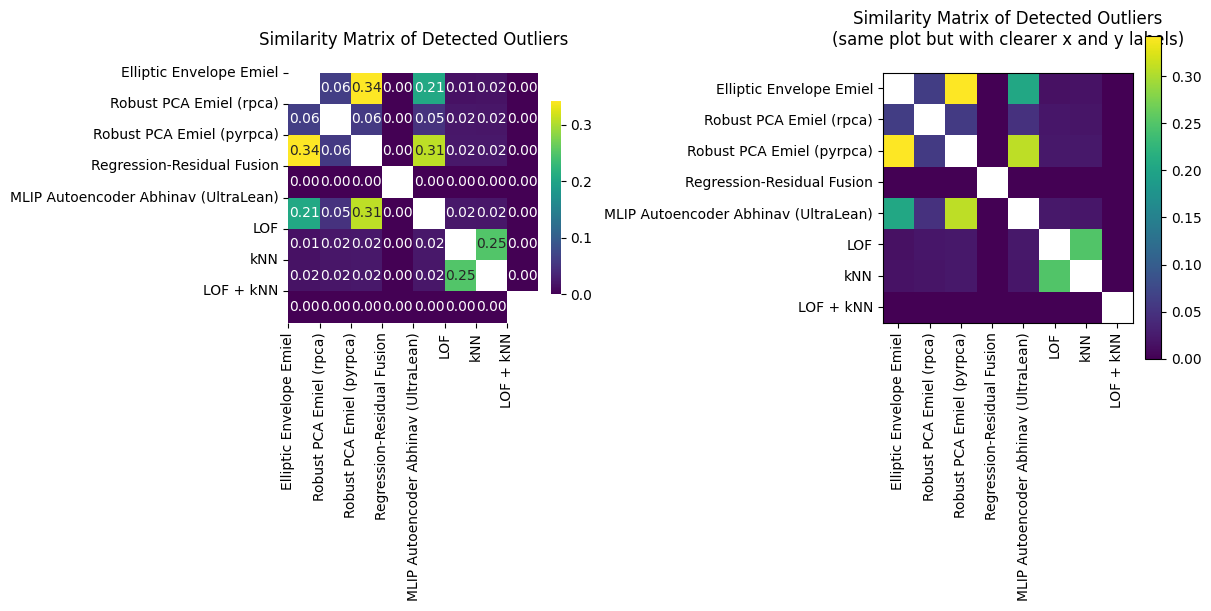

C:\Users\EmielNagel\AppData\Local\Temp\ipykernel_16144\145761337.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.7)


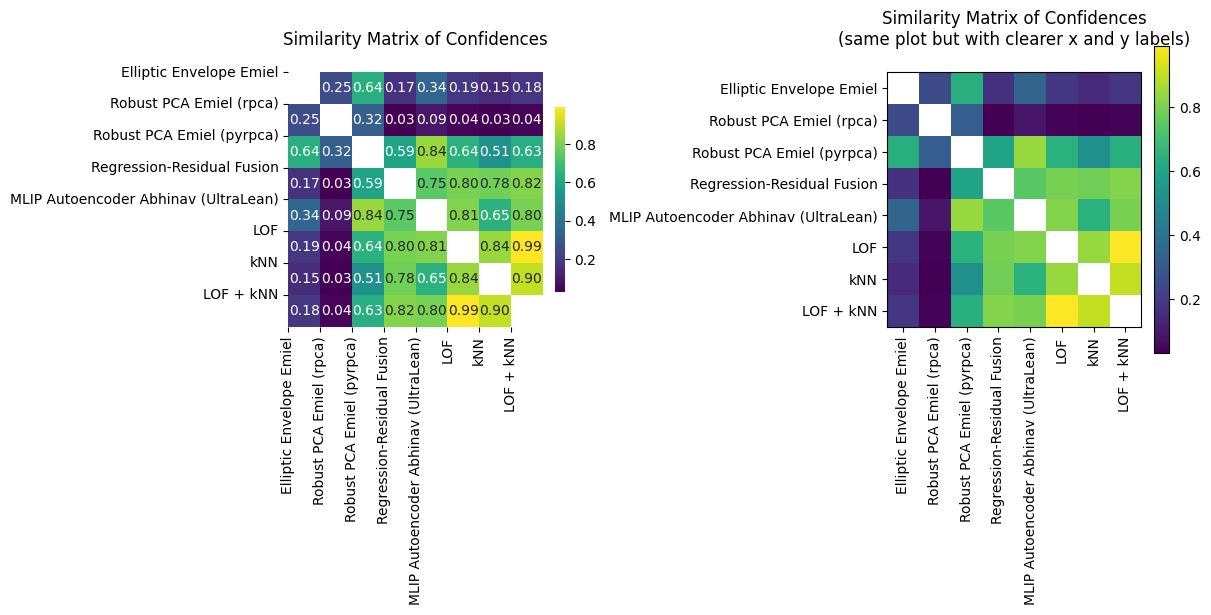

(['Elliptic Envelope Emiel',
  'Robust PCA Emiel (rpca)',
  'Robust PCA Emiel (pyrpca)',
  'Regression-Residual Fusion',
  'MLIP Autoencoder Abhinav (UltraLean)',
  'LOF',
  'kNN',
  'LOF + kNN'],
 array([[       nan, 0.25146987, 0.63691693, 0.17071396, 0.34268554,
         0.18721526, 0.14778801, 0.18348283],
        [0.25146987,        nan, 0.31669607, 0.0322283 , 0.08695502,
         0.04088251, 0.03005045, 0.03955765],
        [0.63691693, 0.31669607,        nan, 0.59328456, 0.84308487,
         0.64449872, 0.51267682, 0.63254628],
        [0.17071396, 0.0322283 , 0.59328456,        nan, 0.74610087,
         0.79548385, 0.78417512, 0.81546218],
        [0.34268554, 0.08695502, 0.84308487, 0.74610087,        nan,
         0.810845  , 0.64595249, 0.7960262 ],
        [0.18721526, 0.04088251, 0.64449872, 0.79548385, 0.810845  ,
                nan, 0.84298756, 0.99235639],
        [0.14778801, 0.03005045, 0.51267682, 0.78417512, 0.64595249,
         0.84298756,        nan, 0.90292773]

In [ ]:
results = detect_all_models()

for model_name, (outliers, confidences) in results.items():
    standard_format.add_outlier_samples(model_name, outliers)
    standard_format.add_confidences(model_name, confidences)

**Run Evaluation**

C:\Users\EmielNagel\AppData\Local\Temp\ipykernel_16144\145761337.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.7)


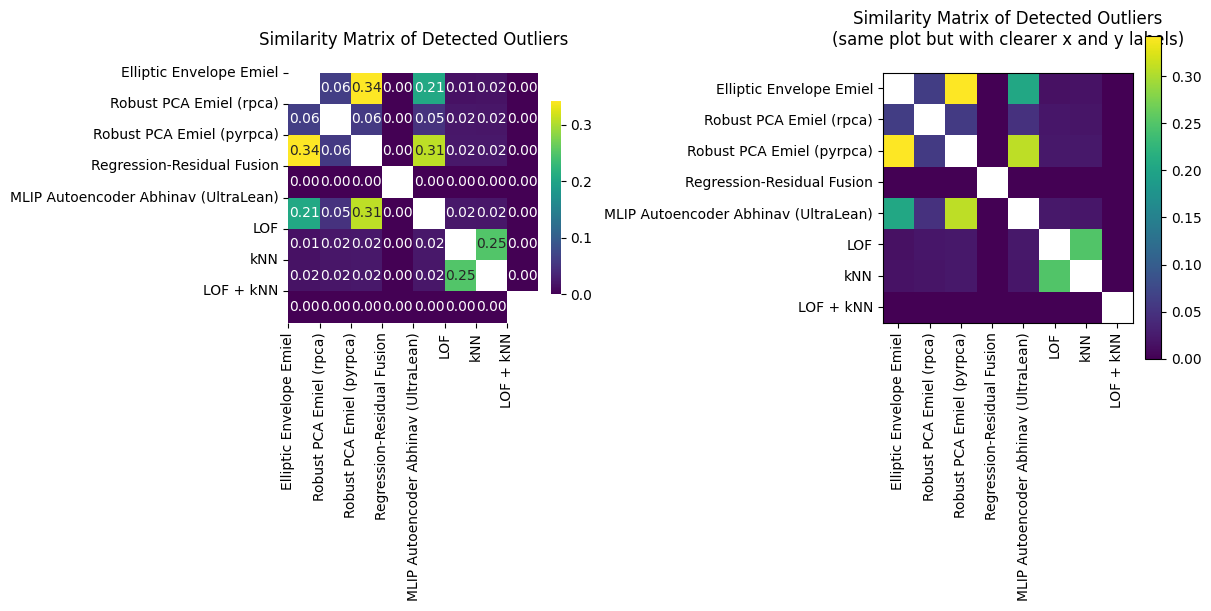

C:\Users\EmielNagel\AppData\Local\Temp\ipykernel_16144\145761337.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.7)


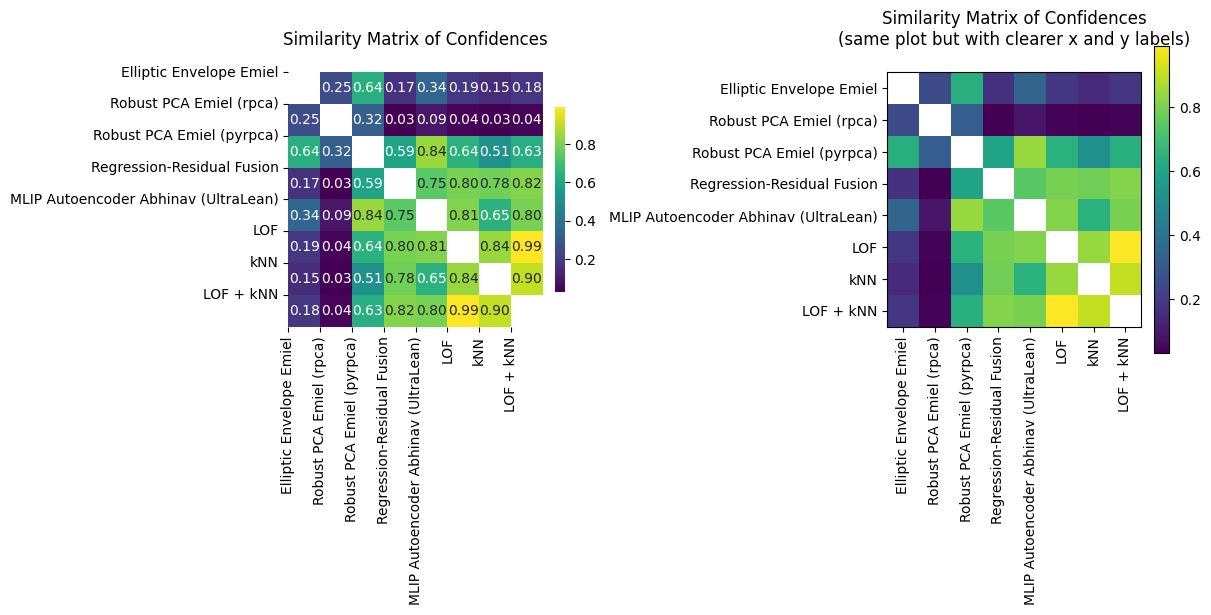

{'Elliptic Envelope Emiel': np.float64(0.05277718104961393), 'Robust PCA Emiel (rpca)': np.float64(0.0), 'Robust PCA Emiel (pyrpca)': np.float64(0.15901647920418108), 'Regression-Residual Fusion': np.float64(0.14762554245654957), 'MLIP Autoencoder Abhinav (UltraLean)': np.float64(0.16333980039055593), 'LOF': np.float64(0.16534377532021627), 'kNN': np.float64(0.14429223874438854), 'LOF + kNN': np.float64(0.16760498283449465)}


In [68]:
standard_format.compute_similarity_scores_detected_outliers(plot_results=True)
models, sim_matrix = standard_format.compute_similarity_scores_confidences(plot_results=True)

agreement_weights = compute_model_agreement_weights(models, sim_matrix)
print(agreement_weights)

In [74]:
output_outliers = {}
for model_name, confidences in standard_format.confidences.items():
    weight = agreement_weights[model_name]
    print(f"Model: {model_name}, Agreement Weight: {weight:.4f}")
    for sample_name, confidence in confidences:
        if sample_name not in output_outliers:
            output_outliers[sample_name] = 0.0
        output_outliers[sample_name] += confidence * weight

selected_outliers = {}
for i in range(20):
    max_sample = max(output_outliers, key=output_outliers.get)
    selected_outliers[max_sample] = output_outliers[max_sample]
    del output_outliers[max_sample]

print(selected_outliers.keys())

def select_samples_by_outlier_score(df, selected_outliers, sample_col="sample_name"):
    sample_names = set(selected_outliers.keys())
    outlier_df = df[df[sample_col].isin(sample_names)].copy()
    outlier_df["outlier_score"] = outlier_df[sample_col].map(selected_outliers)
    outlier_df = outlier_df.sort_values("outlier_score", ascending=False)
    return outlier_df

df = pd.read_csv('Dataset/refData_obf.csv')
outlier_samples_df = select_samples_by_outlier_score(df, selected_outliers, "SampleId")
print(outlier_samples_df)
outlier_samples_df.to_csv("Output/selected_outliers.csv", index=False)

Model: Elliptic Envelope Emiel, Agreement Weight: 0.0528
Model: Robust PCA Emiel (rpca), Agreement Weight: 0.0000
Model: Robust PCA Emiel (pyrpca), Agreement Weight: 0.1590
Model: Regression-Residual Fusion, Agreement Weight: 0.1476
Model: MLIP Autoencoder Abhinav (UltraLean), Agreement Weight: 0.1633
Model: LOF, Agreement Weight: 0.1653
Model: kNN, Agreement Weight: 0.1443
Model: LOF + kNN, Agreement Weight: 0.1676
dict_keys(['sample_15308', 'sample_11363', 'sample_14336', 'sample_7174', 'sample_3372', 'sample_2165', 'sample_15475', 'sample_18429', 'sample_13607', 'sample_8270', 'sample_17353', 'sample_7664', 'sample_2865', 'sample_8120', 'sample_2982', 'sample_15603', 'sample_373', 'sample_11641', 'sample_6692', 'sample_15071'])
           SampleId    A_AL_CO      A_AL_M3    A_AL_RT    A_B_CO     A_B_M3  \
5900   sample_15308   0.040838   350.040584  40.232927  0.225260   7.122565   
1518   sample_11363   0.028180   463.304501  61.408152  0.047079   1.652487   
4820   sample_14336   